Habilitando Mixed Precision para acelerar o treinamento...
Política de precisão global definida.

Iniciando treinamento do modelo (versão para dataset com máscaras)...
Encontrados 735 pares de imagens válidos (com e sem máscara).
Total de Imagens no Dataset: 5000, Passos por Época: 312
Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1545s 5s/step - loss: 0.7697
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1256s 4s/step - loss: 0.5125
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1016s 3s/step - loss: 0.5172
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1049s 3s/step - loss: 0.4707
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 934s 3s/step - loss: 0.4249
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 880s 3s/step - loss: 0.3720
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 824s 3s/step - loss: 0.3176
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 802s 3s/step - loss: 0.2896
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 811s 3s/step - loss: 0.2616
Epoch 10/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 806s 3s/step - loss: 0.2122


Modelo de embedding salvo como 'face_embedding_model_masked.h5'


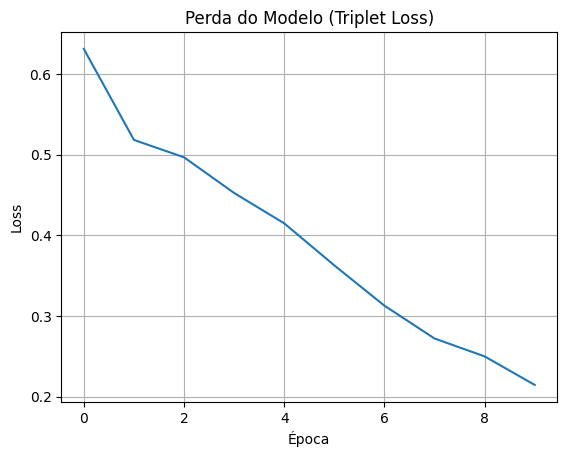

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_981>',)
  • kwargs={'mask': 'None'}

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import cv2
from scipy.spatial.distance import cosine
import random
import matplotlib.pyplot as plt

DATASET_PATH = r"C:\Users\ResTIC16\OneDrive\Desktop\dtlas"


# --- OTIMIZAÇÕES APLICADAS ---
IMG_HEIGHT = 96
IMG_WIDTH = 96
EMBEDDING_DIM = 128
MARGIN = 1.0
BATCH_SIZE = 16
EPOCHS = 10
# -----------------------------

AUTOTUNE = tf.data.AUTOTUNE

# --- 2. GERADOR DE DADOS OTIMIZADO (MODIFICADO) ---

def create_optimized_triplet_dataset(dataset_path, batch_size):
    """
    Cria um pipeline tf.data para o dataset WithMask/WithoutMask.
    """
    path_with_mask = os.path.join(dataset_path, "WithMask")
    path_without_mask = os.path.join(dataset_path, "WithoutMask")

    if not os.path.exists(path_with_mask) or not os.path.exists(path_without_mask):
        raise FileNotFoundError(
            f"As pastas 'WithMask' e 'WithoutMask' não foram encontradas em '{dataset_path}'.\n"
            "Verifique a estrutura do seu diretório e o caminho fornecido."
        )

    # Mapeia cada identidade (ID da pessoa) aos seus respectivos caminhos de imagem
    pessoas_map = {}
    total_images = 0
    
    # Processa a pasta WithMask
    for img_file in os.listdir(path_with_mask):
        pessoa_id = img_file.split('_')[0] # Extrai o ID da pessoa do nome do arquivo (ex: '00001')
        if pessoa_id not in pessoas_map:
            pessoas_map[pessoa_id] = {}
        pessoas_map[pessoa_id]['masked'] = os.path.join(path_with_mask, img_file)
        total_images += 1

    # Processa a pasta WithoutMask
    for img_file in os.listdir(path_without_mask):
        pessoa_id = img_file.split('_')[0]
        if pessoa_id in pessoas_map: # Apenas considera pessoas que têm par com máscara
            pessoas_map[pessoa_id]['unmasked'] = os.path.join(path_without_mask, img_file)

    # Filtra o dicionário para garantir que cada pessoa tenha ambas as imagens (com e sem máscara)
    valid_pairs = {pid: paths for pid, paths in pessoas_map.items() if 'masked' in paths and 'unmasked' in paths}
    pessoa_list = list(valid_pairs.keys())

    if not pessoa_list:
        raise ValueError("Nenhum par de imagens (com/sem máscara) foi encontrado. Verifique os nomes dos arquivos.")

    print(f"Encontrados {len(valid_pairs)} pares de imagens válidos (com e sem máscara).")
    
    def triplet_generator():
        """Gerador Python que produz triplets (âncora, positivo, negativo)."""
        while True:
            # 1. Escolhe uma pessoa para ser âncora e positiva
            pessoa_anc_pos_id = random.choice(pessoa_list)
            
            # 2. Escolhe uma pessoa diferente para ser a negativa
            pessoa_neg_id_list = [p for p in pessoa_list if p != pessoa_anc_pos_id]
            if not pessoa_neg_id_list:
                continue # Pula caso haja apenas uma pessoa
            pessoa_neg_id = random.choice(pessoa_neg_id_list)
            
            # 3. Define os caminhos de âncora e positivo da mesma pessoa
            #    Alterna aleatoriamente se a âncora é com ou sem máscara
            if random.random() > 0.5:
                ancora_path = valid_pairs[pessoa_anc_pos_id]['masked']
                positiva_path = valid_pairs[pessoa_anc_pos_id]['unmasked']
            else:
                ancora_path = valid_pairs[pessoa_anc_pos_id]['unmasked']
                positiva_path = valid_pairs[pessoa_anc_pos_id]['masked']

            # 4. Define o caminho negativo de uma pessoa diferente
            #    A imagem negativa também pode ser com ou sem máscara
            if random.random() > 0.5:
                negativa_path = valid_pairs[pessoa_neg_id]['masked']
            else:
                negativa_path = valid_pairs[pessoa_neg_id]['unmasked']

            yield ancora_path, positiva_path, negativa_path

    dataset = tf.data.Dataset.from_generator(
        triplet_generator,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    )

    def _load_and_preprocess_image(img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = img / 255.0
        return img

    def load_triplet_images(anc_path, pos_path, neg_path):
        return (
            _load_and_preprocess_image(anc_path),
            _load_and_preprocess_image(pos_path),
            _load_and_preprocess_image(neg_path)
        )

    dataset = dataset.map(load_triplet_images, num_parallel_calls=AUTOTUNE)

    def format_dataset_entry(anc_img, pos_img, neg_img):
        return {"anchor_input": anc_img, "positive_input": pos_img, "negative_input": neg_img}, tf.zeros(())

    dataset = dataset.map(format_dataset_entry, num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset, total_images


# --- 3. CRIAÇÃO DO MODELO (Sem alterações) ---

def create_embedding_network(embedding_dim=EMBEDDING_DIM):
    """Cria a rede neural que gera os vetores (embeddings)."""
    base_model = keras.applications.MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet',
        alpha=0.35
    )
    base_model.trainable = True
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(embedding_dim, dtype='float32')(x)
    embeddings = layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=1), name="L2_Normalization", dtype='float32')(x)
    return keras.Model(inputs, embeddings, name="EmbeddingNet")

def triplet_loss(y_true, y_pred, margin=MARGIN):
    """Calcula a Triplet Loss."""
    anchor, positive, negative = y_pred[:, :EMBEDDING_DIM], y_pred[:, EMBEDDING_DIM:2*EMBEDDING_DIM], y_pred[:, 2*EMBEDDING_DIM:]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)

class TripletModel(keras.Model):
    """Modelo customizado que encapsula a rede e a lógica de treinamento."""
    def __init__(self, embedding_net, **kwargs):
        super().__init__(**kwargs)
        self.embedding_net = embedding_net

    def call(self, inputs):
        anchor_embedding = self.embedding_net(inputs["anchor_input"])
        positive_embedding = self.embedding_net(inputs["positive_input"])
        negative_embedding = self.embedding_net(inputs["negative_input"])
        return tf.concat([anchor_embedding, positive_embedding, negative_embedding], axis=1)


# --- 4. SISTEMA DE RECONHECIMENTO FACIAL (MODIFICADO) ---

class FaceRecognitionSystem:
    def __init__(self, model_path, img_size=(IMG_WIDTH, IMG_HEIGHT)):
        self.embedding_model = keras.models.load_model(model_path, custom_objects={"triplet_loss": triplet_loss})
        self.img_size = img_size
        self.database = {}

    def _preprocess_image(self, img_path):
        img = cv2.imread(img_path)
        if img is None: return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv.resize(img, self.img_size)
        img = img.astype(np.float32) / 255.0
        return img

    def create_database(self, dataset_path, batch_size=32):
        """
        Função modificada para criar o banco de dados a partir das imagens SEM MÁSCARA.
        O vetor médio será calculado usando apenas as imagens da pasta 'WithoutMask'
        para ter uma representação "limpa" da face.
        """
        print("Criando banco de dados de embeddings (usando apenas imagens 'WithoutMask')...")
        path_without_mask = os.path.join(dataset_path, "WithoutMask")
        
        if not os.path.exists(path_without_mask):
             raise FileNotFoundError(f"Pasta 'WithoutMask' não encontrada em: {dataset_path}")

        image_paths = [os.path.join(path_without_mask, f) for f in os.listdir(path_without_mask)]
        if not image_paths:
            print("Nenhuma imagem encontrada na pasta 'WithoutMask'.")
            return

        # Para esta estrutura, o "nome da pessoa" é o ID extraído do arquivo
        # Agrupamos todas as imagens por ID de pessoa
        person_images = {}
        for img_path in image_paths:
            person_id = os.path.basename(img_path).split('_')[0]
            if person_id not in person_images:
                person_images[person_id] = []
            person_images[person_id].append(img_path)

        for person_id, paths in sorted(person_images.items()):
            processed_images_batch = [self._preprocess_image(p) for p in paths if self._preprocess_image(p) is not None]
            if not processed_images_batch: continue

            img_array = np.array(processed_images_batch)
            embeddings = self.embedding_model.predict(img_array, batch_size=batch_size, verbose=0)
            
            # Usamos a média dos embeddings das imagens sem máscara para representar a pessoa
            self.database[person_id] = np.mean(embeddings, axis=0)
            print(f"-> Vetor médio criado para a pessoa ID: {person_id}")

        print("Banco de dados criado com sucesso!")


    def recognize_face(self, img_path, threshold=0.7):
        if not self.database:
            print("Erro: Banco de dados está vazio.")
            return "Desconhecido", 0.0

        processed_img = self._preprocess_image(img_path)
        if processed_img is None:
            return "Erro ao ler imagem", 0.0

        unknown_embedding = self.embedding_model.predict(np.expand_dims(processed_img, axis=0), verbose=0)[0]

        min_dist = float("inf")
        recognized_id = "Desconhecido"
        for person_id, db_embedding in self.database.items():
            dist = cosine(unknown_embedding, db_embedding)
            if dist < min_dist:
                min_dist = dist
                recognized_id = person_id

        if min_dist > threshold:
            recognized_id = "Desconhecido"
            
        confidence = (1 - min_dist)
        return recognized_id, confidence

    def save_database(self, path="face_database_masked.npy"):
        np.save(path, self.database)
        print(f"Banco de dados salvo em: {path}")

    def load_database(self, path="face_database_masked.npy"):
        if os.path.exists(path):
            self.database = np.load(path, allow_pickle=True).item()
            print(f"Banco de dados carregado de: {path}")
        else:
            print(f"Arquivo de banco de dados não encontrado: {path}")


# --- 5. FLUXO PRINCIPAL DE EXECUÇÃO ---

if __name__ == "__main__":
    MODEL_FILENAME = "face_embedding_model_masked.h5"
    DB_FILENAME = "face_database_masked.npy"

    # --- ETAPA 1: TREINAMENTO ---
    if not os.path.exists(MODEL_FILENAME):
        print("Habilitando Mixed Precision para acelerar o treinamento...")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print('Política de precisão global definida.')

        print("\nIniciando treinamento do modelo (versão para dataset com máscaras)...")

        embedding_net = create_embedding_network()
        triplet_model = TripletModel(embedding_net)

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        optimizer = tf.keras.optimizers.LossScaleOptimizer(optimizer)

        triplet_model.compile(optimizer=optimizer, loss=triplet_loss)

        try:
            train_dataset, num_images = create_optimized_triplet_dataset(DATASET_PATH, BATCH_SIZE)
            STEPS_PER_EPOCH = max(1, num_images // BATCH_SIZE)
            print(f"Total de Imagens no Dataset: {num_images}, Passos por Época: {STEPS_PER_EPOCH}")

            history = triplet_model.fit(
                train_dataset,
                steps_per_epoch=STEPS_PER_EPOCH,
                epochs=EPOCHS,
                verbose=1
            )
            
            embedding_net.save(MODEL_FILENAME)
            print(f"Modelo de embedding salvo como '{MODEL_FILENAME}'")

            plt.plot(history.history['loss'])
            plt.title('Perda do Modelo (Triplet Loss)')
            plt.ylabel('Loss')
            plt.xlabel('Época')
            plt.grid(True)
            plt.show()

        except (FileNotFoundError, ValueError) as e:
            print(f"\nERRO: O treinamento não pôde ser iniciado. Razão: {e}")
            print("Por favor, verifique o caminho do dataset e a estrutura das pastas.")

    else:
        print(f"Modelo '{MODEL_FILENAME}' já existe. Pulando treinamento.")

    # --- ETAPA 2: CRIAÇÃO/CARREGAMENTO DO BANCO DE DADOS ---
    if os.path.exists(MODEL_FILENAME):
        face_system = FaceRecognitionSystem(model_path=MODEL_FILENAME)
        
        if not os.path.exists(DB_FILENAME):
             # A criação do banco de dados depende do dataset original
            if os.path.exists(os.path.join(DATASET_PATH, "WithoutMask")):
                face_system.create_database(DATASET_PATH)
                face_system.save_database(DB_FILENAME)
            else:
                 print(f"\nAVISO: Não foi possível criar o banco de dados pois o caminho '{DATASET_PATH}' não contém a pasta 'WithoutMask'.")
        else:
            face_system.load_database(DB_FILENAME)
    else:
        print("\nAVISO: Modelo não encontrado. Pule a criação do banco de dados e o reconhecimento.")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# --- 1. CONFIGURAÇÃO ---
# Verifique se estes nomes e caminhos estão corretos
MODEL_FILENAME = "face_embedding_model_masked.h5"
DB_FILENAME = "face_database_masked.npy"

# Coloque o caminho da imagem da nova pessoa aqui
NEW_PERSON_IMAGE_PATH = r"C:\Users\ResTIC16\OneDrive\Desktop\dtlas/marcelinho_no_db.jpg"

# Defina um ID único para a nova pessoa
NEW_PERSON_ID = "marcelinho_01" 

# --- 2. DEFINIÇÕES TÉCNICAS (Necessárias para o modelo) ---
IMG_WIDTH, IMG_HEIGHT = 96, 96

# Camada customizada que precisa ser definida para carregar o modelo
class L2Normalization(layers.Layer):
    def __init__(self, **kwargs):
        super(L2Normalization, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=1)
    def get_config(self):
        config = super(L2Normalization, self).get_config()
        return config

# Função para pré-processar a imagem
def preprocess_single_image(img_path, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    return img.astype(np.float32) / 255.0

# --- 3. FUNÇÃO PRINCIPAL (Lógica organizada) ---
def add_or_update_person_in_db(person_id, image_path, model_path, db_path):
    """
    Carrega o modelo e o banco de dados, e adiciona ou atualiza o embedding de uma pessoa.
    """
    print(f"--- INICIANDO PROCESSO PARA ID: {person_id} ---")

    # Passo 1: Verificar se todos os arquivos necessários existem
    if not os.path.exists(model_path):
        print(f"ERRO CRÍTICO: Arquivo do modelo não encontrado em '{model_path}'")
        return
    if not os.path.exists(db_path):
        print(f"ERRO CRÍTICO: Arquivo do banco de dados não encontrado em '{db_path}'")
        return
    
    # Normaliza o caminho da imagem para evitar erros de SO
    norm_image_path = os.path.normpath(image_path)
    if not os.path.exists(norm_image_path):
        print(f"ERRO CRÍTICO: Imagem da pessoa não encontrada em '{norm_image_path}'")
        return

    # Passo 2: Tentar carregar o sistema e processar a imagem
    try:
        print("Carregando modelo e banco de dados existente...")
        embedding_model = keras.models.load_model(model_path, custom_objects={"L2Normalization": L2Normalization})
        database = np.load(db_path, allow_pickle=True).item()
        
        if person_id in database:
            print(f"AVISO: O ID '{person_id}' já existe. A entrada será atualizada com a nova imagem.")

        print(f"Processando nova imagem: {norm_image_path}")
        processed_img = preprocess_single_image(norm_image_path)

        if processed_img is None:
            print(f"ERRO: Falha ao ler ou processar a imagem em '{norm_image_path}'.")
            return
            
        # Passo 3: Gerar embedding, atualizar e salvar
        new_embedding = embedding_model.predict(np.expand_dims(processed_img, axis=0), verbose=0)[0]
        database[person_id] = new_embedding
        np.save(db_path, database)
        
        print("\n--- SUCESSO! ---")
        print(f"Pessoa com ID '{person_id}' foi adicionada/atualizada no banco de dados.")
        print(f"O arquivo '{db_path}' agora contém {len(database)} identidades.")

        # Mostra a imagem adicionada para confirmação
        img_to_display = cv2.cvtColor(cv2.imread(norm_image_path), cv2.COLOR_BGR2RGB)
        plt.imshow(img_to_display)
        plt.title(f"Imagem Adicionada para o ID: {person_id}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"\nOcorreu um erro inesperado durante a operação: {e}")

# --- 4. EXECUÇÃO ---
# Chama a função principal com as configurações definidas no início do script.
if __name__ == "__main__":
    add_or_update_person_in_db(
        person_id=NEW_PERSON_ID,
        image_path=NEW_PERSON_IMAGE_PATH,
        model_path=MODEL_FILENAME,
        db_path=DB_FILENAME
    )

--- INICIANDO PROCESSO PARA ID: marcelinho_01 ---
ERRO CRÍTICO: Arquivo do banco de dados não encontrado em 'face_database_masked.npy'


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import cv2
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# --- 1. CONFIGURAÇÃO ---
MODEL_FILENAME = "face_embedding_model_masked.h5"
DB_FILENAME = "face_database_masked.npy"

# !!! IMPORTANTE: COLOQUE AQUI O CAMINHO DA IMAGEM DO MARCELINHO COM MÁSCARA !!!
IMAGE_TO_RECOGNIZE_PATH = r"C:\Caminho\Para\Sua\Imagem\marcelinho_na_inferencia.jpg" # <--- ALTERE ESTA LINHA

# --- 2. DEFINIÇÕES TÉCNICAS (Necessárias para o modelo) ---
IMG_WIDTH, IMG_HEIGHT = 96, 96

# Camada customizada que precisa ser definida para carregar o modelo
class L2Normalization(layers.Layer):
    def __init__(self, **kwargs):
        super(L2Normalization, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=1)
    def get_config(self):
        config = super(L2Normalization, self).get_config()
        return config

# Função para pré-processar a imagem de entrada
def preprocess_single_image(img_path, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converte para RGB para Matplotlib
    img = cv2.resize(img, img_size)
    return img.astype(np.float32) / 255.0

# --- 3. LÓGICA DE RECONHECIMENTO FACIAL ---
def recognize_person(image_path, model_path, db_path, threshold=0.7):
    """
    Carrega o sistema e reconhece uma pessoa em uma única imagem.
    """
    print("--- INICIANDO RECONHECIMENTO FACIAL ---")

    # Validar se todos os arquivos necessários existem
    if not os.path.exists(model_path):
        print(f"ERRO: Modelo não encontrado em '{model_path}'. Execute as etapas anteriores.")
        return
    if not os.path.exists(db_path):
        print(f"ERRO: Banco de dados não encontrado em '{db_path}'. Execute as etapas anteriores.")
        return
    norm_image_path = os.path.normpath(image_path)
    if not os.path.exists(norm_image_path):
        print(f"ERRO: Imagem de teste não encontrada em '{norm_image_path}'. Verifique o caminho.")
        return
        
    try:
        # Carregar o modelo e o banco de dados
        print("Carregando modelo e banco de dados...")
        embedding_model = keras.models.load_model(model_path, custom_objects={"L2Normalization": L2Normalization})
        database = np.load(db_path, allow_pickle=True).item()
        print(f"Banco de dados carregado com {len(database)} identidades.")

        # Processar a imagem de teste
        print(f"Processando imagem: {norm_image_path}")
        processed_img = preprocess_single_image(norm_image_path)
        if processed_img is None:
            print("ERRO: Falha ao ler a imagem.")
            return

        # Gerar o embedding (assinatura facial)
        unknown_embedding = embedding_model.predict(np.expand_dims(processed_img, axis=0), verbose=0)[0]

        # Comparar com todos no banco de dados
        min_dist = float("inf")
        recognized_id = "Desconhecido"
        for person_id, db_embedding in database.items():
            dist = cosine(unknown_embedding, db_embedding)
            if dist < min_dist:
                min_dist = dist
                recognized_id = person_id

        # Aplicar o limiar de decisão
        if min_dist > threshold:
            recognized_id = "Desconhecido"
        confidence = (1 - min_dist)

        # Exibir o resultado final
        print("\n--- RESULTADO DO RECONHECIMENTO ---")
        print(f"Pessoa reconhecida como: '{recognized_id}'")
        print(f"Confiança: {confidence:.2%}")
        print(f"Distância (similaridade): {min_dist:.4f} (quanto menor, mais similar)")

        img_to_display = cv2.cvtColor(cv2.imread(norm_image_path), cv2.COLOR_BGR2RGB)
        plt.imshow(img_to_display)
        plt.title(f"Reconhecido como: {recognized_id} ({confidence:.1%})")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"\nOcorreu um erro inesperado: {e}")

# --- 4. EXECUÇÃO ---
# Chama a função de reconhecimento com as configurações definidas
if __name__ == "__main__":
    recognize_person(
        image_path=IMAGE_TO_RECOGNIZE_PATH,
        model_path=MODEL_FILENAME,
        db_path=DB_FILENAME
    )

--- INICIANDO RECONHECIMENTO FACIAL ---
ERRO: Banco de dados não encontrado em 'face_database_masked.npy'. Execute as etapas anteriores.
